## Using the dev branch of SimPEG (http://github.com/simpeg/simpeg)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json

import properties
from SimPEG import *
from SimPEG.EM import FDEM, mu_0
from pymatsolver import PardisoSolver as Solver

from CasingSimulations import CasingMesh, DownHoleCasingSrc, TopCasingSource

%matplotlib inline

# set a nice colormap
plt.set_cmap(plt.get_cmap('viridis'))

In [2]:
directory = 'em_6_casing_10ohmm_overmu'
cpfile = "CasingProperties.json"
resultsfile = "em_6_casing.hdf5"
rerun = True 

# Model Parameters

In [3]:
casing_l = 1000.
dsz = -casing_l + 50. 
freqs = [2.]#[1e-1, 0.5, 1, 2, 5]

In [4]:
# Parameters to set up the model
class CasingProperties(properties.HasProperties):

    # Conductivities
    sigmaair = properties.Float(
        "conductivity of the air (S/m)",
        default=1e-8
    )

    sigmaback = properties.Float(
        "conductivity of the background (S/m)",
        default=1e-1
    )

    sigmalayer = properties.Float(
        "conductivity of the layer (S/m)",
        default=1e-1
    )

    sigmacasing = properties.Float(
        "conductivity of the casing (S/m)",
        default=5.5e6
    )

    sigmainside = properties.Float(
        "conductivity of the fluid inside the casing (S/m)",
        default=1.
    )

    # Magnetic Permeability
    muModels = properties.Array(
        "permeability of the casing",
        default= [0., 50., 100., 150., 200.],
        dtype = float
    )

    # Casing Geometry
    casing_top = properties.Float(
        "top of the casing (m)",
        default=0.
    )
    casing_l = properties.Float(
        "length of the casing (m)",
        default=1000
    )

    casing_d = properties.Float(
        "diameter of the casing (m)",
        default=10e-2
    ) # 10cm diameter

    casing_t = properties.Float(
        "thickness of the casing (m)",
        default=1e-2
    ) # 1cm thickness

    # Layer Geometry
    layer_z = properties.Array(
        "z-limits of the layer",
        shape=(2,),
        default=np.r_[-1000., -900.]
    )

    freqs = properties.Array(
        "source frequencies",
        default=np.r_[1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1],
        dtype=float
    )

    dsz = properties.Float(
        "down-hole z-location for the source",
        default=-950.
    )

    src_b = properties.Array(
        "B electrode location",
        default=np.r_[1e4, 0., 0.]
    )

    @property
    def src_a(self):
        return np.r_[0., 0., self.dsz]

    # useful quantities to work in
    @property
    def casing_r(self):
        return self.casing_d/2.

    @property
    def casing_a(self):
        return self.casing_r - self.casing_t/2.  # inner radius

    @property
    def casing_b(self):
        return self.casing_r + self.casing_t/2.  # outer radius

    @property
    def casing_z(self):
        return np.r_[-self.casing_l, 0.] + self.casing_top

In [5]:
# Save or load Results
cp_file = '{directory}/{cpfile}'.format(directory=directory, cpfile=cpfile)

if rerun is True:   
    cp = CasingProperties(casing_l=casing_l, dsz=dsz)
    cp.freqs = freqs
else:   
    with open(cp_file, 'r') as outfile:   
        cp = CasingProperties.deserialize(json.load(outfile))

In [6]:
CMesh = CasingMesh(cp)
CMesh.npadx2 = CMesh.npadx2 - 3
CMesh.npadzu = CMesh.npadzu - 3
CMesh.npadzd = CMesh.npadzd - 3
mesh = CMesh.mesh

In [7]:
print(
    'Cyl Mesh Extent xmax: {},: zmin: {}, zmax: {}'.format(
        mesh.vectorCCx.max(),
        mesh.vectorCCz.min(),
        mesh.vectorCCz.max()
    )
)

print(mesh.nC)
print([500./np.sqrt(cp.sigmaback*f) for f in cp.freqs])
print([500./np.sqrt(cp.sigmacasing*f) for f in cp.freqs])

Cyl Mesh Extent xmax: 208853.54563,: zmin: -183013.550756, zmax: 182014.050756
2389520
[1118.0339887498949]
[0.15075567228888181]


# plot model

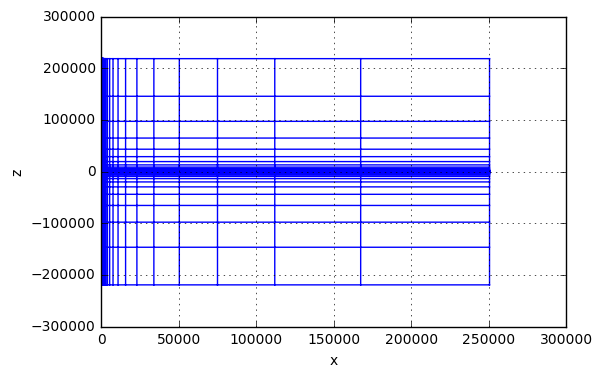

In [8]:
fig, ax = plt.subplots(1,1)
mesh.plotGrid(ax=ax)

# fig.savefig('{}/{}'.format(directory, 'CylMesh.png'))

In [9]:
indActive=mesh.gridCC[:,2] <= 0.
casingMap = Maps.ParametrizedCasingAndLayer(mesh, indActive=indActive, slope=1e8)
actMap_sigma = Maps.InjectActiveCells(mesh, indActive=indActive, valInactive=np.log(cp.sigmaair))
actMap_mu = Maps.InjectActiveCells(mesh, indActive=indActive, valInactive=mu_0)
expMap = Maps.ExpMap(mesh)

sigmaMap = expMap * actMap_sigma * casingMap
muMap = actMap_mu * casingMap

In [10]:
muModelInd = 0

sigma_m = np.r_[
    np.log(cp.sigmaback), np.log(cp.sigmalayer), np.log(cp.sigmacasing), np.log(cp.sigmainside),
    cp.layer_z.mean(), cp.layer_z[1] - cp.layer_z[0], cp.casing_r, cp.casing_t, 
    cp.casing_z[0], cp.casing_z[1]
]

mu_m = np.r_[
    mu_0, mu_0, cp.muModels[muModelInd]*mu_0, mu_0,
    cp.layer_z.mean(), cp.layer_z[1] - cp.layer_z[0], cp.casing_r, cp.casing_t, 
    cp.casing_z[0], cp.casing_z[1]
]

In [11]:
def MuCasingModel(mucasing):
    return np.r_[
        mu_0, mu_0, mucasing*mu_0, mu_0,
        cp.layer_z.mean(), cp.layer_z[1] - cp.layer_z[0], cp.casing_r, cp.casing_t, 
        cp.casing_z[0], cp.casing_z[1]
    ]

In [12]:
%%time
sigma = sigmaMap * sigma_m
mu = muMap * mu_m

CPU times: user 22.9 s, sys: 646 ms, total: 23.6 s
Wall time: 25.2 s


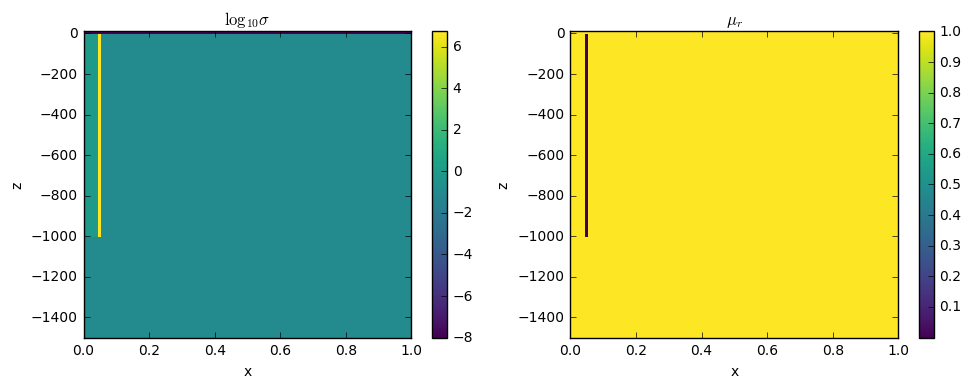

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

plt.colorbar(mesh.plotImage(np.log10(sigma), ax=ax[0])[0], ax=ax[0])
plt.colorbar(mesh.plotImage(mu/mu_0, ax=ax[1])[0], ax=ax[1])

xlim = np.r_[0., 1.]
zlim = np.r_[-1500., 10.]

ax[0].set_xlim(xlim)
ax[1].set_xlim(xlim)

ax[0].set_ylim(zlim)
ax[1].set_ylim(zlim)

ax[0].set_title('$\log_{10}\sigma$')
ax[1].set_title('$\mu_r$')

plt.tight_layout()
plt.show()

# fig.savefig('{}/{}'.format(directory, 'PhysPropModels'))

# Set up the Source

In [14]:
# down-holeSource
dhSrc = DownHoleCasingSrc(mesh, cp.src_a, cp.src_b, cp.casing_a, cp.freqs)
thSrc = TopCasingSource(mesh, np.r_[0.,0.,0], cp.src_b, cp.casing_a, cp.freqs)

(-951, -949)

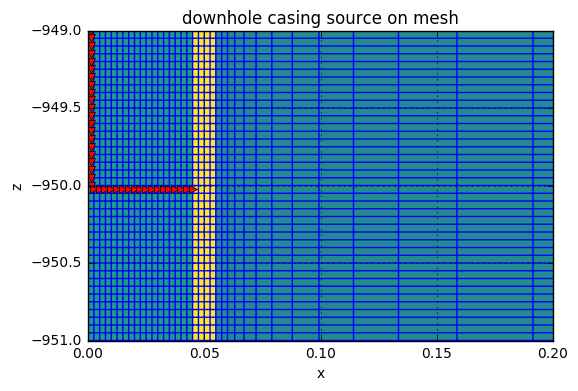

In [15]:
# Plot the source to make sure the path is infact
# connected

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
mesh.plotImage(np.log10(sigma), ax=ax)
mesh.plotGrid(ax=ax)
dhSrc.plotSrc(ax=ax)

ax.set_title('downhole casing source on mesh')

ax.set_xlim([0, 0.2])
ax.set_ylim([-951, -949])

# fig.savefig('{}/{}'.format(directory, 'SourceOnMesh.png'))

# Problem and Survey

In [16]:
prob = FDEM.Problem3D_h(mesh, sigma=sigma, muMap=muMap)
survey = FDEM.Survey(dhSrc.s_e + thSrc.s_e)
prob.solver = Solver
prob.pair(survey)

In [17]:
def MuCasingModel(mucasing):
    return np.r_[
        mu_0, mu_0, mucasing*mu_0, mu_0,
        cp.layer_z.mean(), cp.layer_z[1] - cp.layer_z[0], cp.casing_r, cp.casing_t, 
        cp.casing_z[0], cp.casing_z[1]
    ]

In [18]:
# cp.muModels = [1., 50., 100., 200.]
fields = {}

In [19]:
if rerun is True:
    # create a file to store results
    results = h5py.File("{}/{}".format(directory, resultsfile), "w")
else:
    results = h5py.File("{}/{}".format(directory, resultsfile), "r")

In [20]:
results.keys()

[]

In [21]:
%%time
for muMod in cp.muModels:
    tag = int(muMod)
    curMu = MuCasingModel(muMod)

    if rerun is True:
        print('solving mu = {}mu_0'.format(tag))
        fields[tag] = prob.fields(curMu)
        dbentry = "fields_{tag}".format(tag=tag)
        results.create_dataset(dbentry, data=fields[tag][:,'hSolution'])
        print('... saved fields_{tag}'.format(tag=tag))
        
        # Save parameters used to produce these fields
        with open(cp_file, 'w') as outfile:
            json.dump(cp.serialize(), outfile)

    else:
        print('loading mu = {}mu_0'.format(tag))
        prob.model = curMu
        f = prob.fieldsPair(mesh, survey)
        f[:, 'hSolution'] = results['fields_{}'.format(tag)].value
        fields[tag] = f
        print('... loaded mu = {}mu_0'.format(tag))

solving mu = 0mu_0
... saved fields_0
solving mu = 50mu_0
... saved fields_50
solving mu = 100mu_0
... saved fields_100
solving mu = 150mu_0
... saved fields_150
solving mu = 200mu_0
... saved fields_200
CPU times: user 16min 8s, sys: 1min 31s, total: 17min 39s
Wall time: 12min 27s


In [22]:
from ipywidgets import widgets
from matplotlib.colors import LogNorm

In [23]:
start_points = Utils.ndgrid(np.arange(-0.1, 0.1, step=0.05), np.arange(-1300., 0., step=50))
start_points.shape

(104, 2)

2.0 Hz, 150.0 mu_0


((<matplotlib.collections.QuadMesh at 0x128b58ad0>,
  <matplotlib.streamplot.StreamplotSet at 0x12b40c450>),
 <matplotlib.axes._subplots.AxesSubplot at 0x114d1e290>)

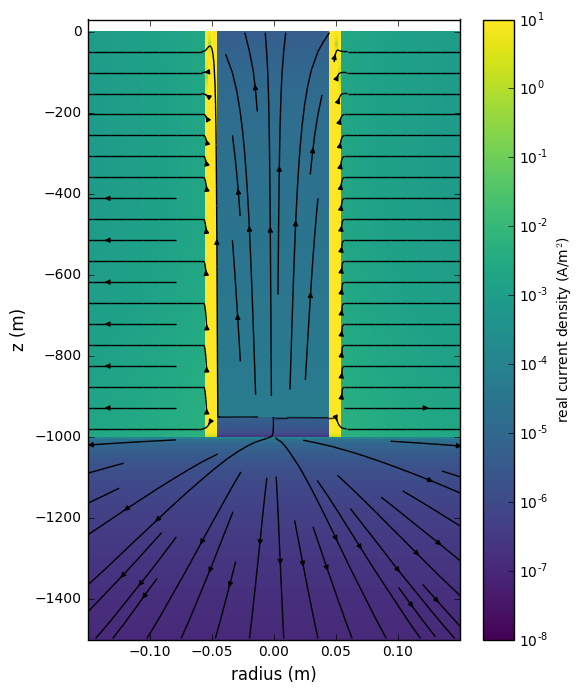

In [24]:
saveFig = False

def vecplot_j(muind, freqind, reim='real', th_bh='bh', fig=None, ax=None, saveFig=False, colorbar=True):
    if ax is None: 
        fig, ax = plt.subplots(1,1, figsize=(6,8))
    
    fontsize = 12
    
    xlim = np.r_[-1, 1] * 0.15
    ylim = np.r_[-1500., 30.]
    clim = np.r_[1e-8, 1e1]
    
    range_x=np.r_[-1., 1.]*0.2
    range_y=np.r_[-1500., 0.]
    sample_grid = np.r_[mesh.hx.min(), 5.]
    
    src = survey.getSrcByFreq(survey.freqs[freqind])
    src = src[0] if th_bh == 'bh' else src[1]
    mur = cp.muModels[muind]
    
    jplot = getattr(fields[mur][src, 'j'], reim)
    
    print('{} Hz, {} mu_0'.format(cp.freqs[freqind], mur))

#     start_points = Utils.ndgrid(np.arange(-0.1, 0.1, step=0.025),np.r_[-100., -500., 0.])
    
    streamOpts = {'color': 'k'}
    pcolorOpts = {
            'norm':LogNorm(), 'cmap': plt.get_cmap('viridis')
        }
    
    if saveFig is True:
        streamOpts['arrowsize']= 6

    f = mesh.plotImage(
        jplot, vType='F', view='vec',
        pcolorOpts=pcolorOpts,
        streamOpts=streamOpts,
        mirror=True, range_x=range_x, range_y=range_y, 
        sample_grid = sample_grid,
        ax=ax
    )
    
    if colorbar is True: 
        plt.colorbar(
            f[0], label='{} current density (A/m$^2$)'.format(
                reim
            ), ax=ax
        )

    if clim is not None:
        f[0].set_clim(clim)

    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    # ax.set_title('Current Density')
    ax.set_xlabel('radius (m)', fontsize=fontsize)
    ax.set_ylabel('z (m)', fontsize=fontsize)
    
    return f, ax
    
#     plt.show()

plot_j_widget = lambda muind, freqind, reim, th_bh: vecplot_j(
    muind=muind, freqind=freqind, reim=reim, th_bh=th_bh, fig=None, ax=None, colorbar=True
)
    
w = widgets.interactive(
        plot_j_widget, muind=widgets.IntSlider(min=0, max=len(cp.muModels)-1, continuousUpdate=False),
        freqind=widgets.IntSlider(min=0, max=len(cp.freqs)-1, continuousUpdate=False),
        reim=widgets.ToggleButtons(options=['real', 'imag'], continuousUpdate=False), 
        th_bh=widgets.ToggleButtons(options=['th', 'bh'], continuousUpdate=False)
)
w
#ax.axis('equal', adjustable='box')

2.0 Hz, 100.0 mu_0
2.0 Hz, 100.0 mu_0
saving Figure


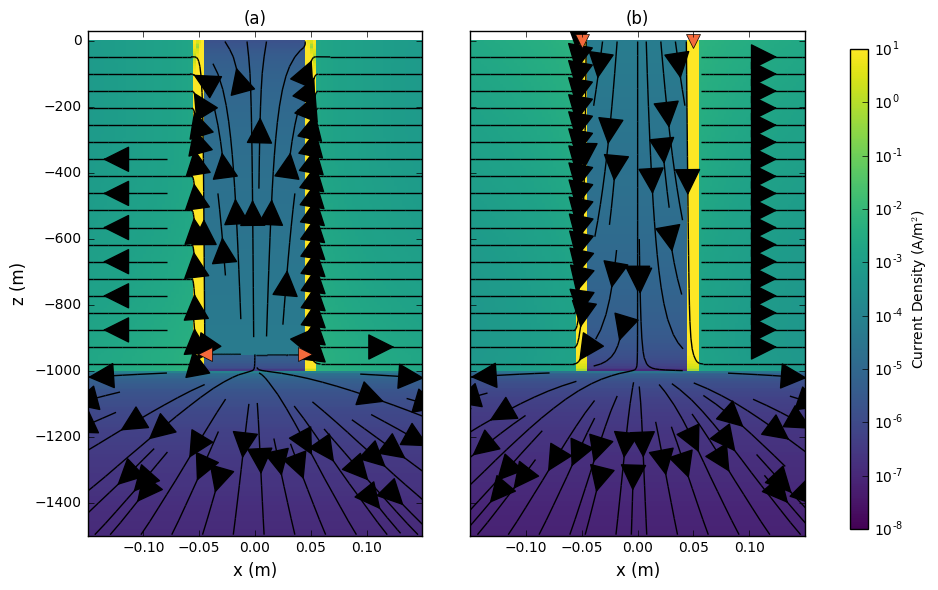

In [30]:
saveFig = True

muind = 2
freqind = 0
reim = 'real'

fig, ax = plt.subplots(1,2, figsize=(9,6))

f0, _ = vecplot_j(muind, freqind, reim=reim, th_bh='bh', ax=ax[0], fig=fig, saveFig=saveFig, colorbar=False)
f1, _ = vecplot_j(muind, freqind, reim=reim, th_bh='th', ax=ax[1], fig=fig, saveFig=saveFig, colorbar=False)


ax[0].plot(cp.casing_a, dsz, '>', color=np.r_[239, 104, 59]/250., markersize=10)
ax[0].plot(-1.*cp.casing_a, dsz, '<', color=np.r_[239, 104, 59]/250., markersize=10)

ax[1].plot(cp.casing_r, 0, 'v', color=np.r_[239, 104, 59]/250., markersize=10)
ax[1].plot(-1.*cp.casing_r, 0, 'v', color=np.r_[239, 104, 59]/250., markersize=10)

ax[0].set_title('(a)')
ax[1].set_title('(b)')
ax[1].set_ylabel('')
ax[1].set_yticklabels([])

ax[0].set_xlabel('x (m)')
ax[1].set_xlabel('x (m)')

plt.tight_layout()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.11, 0.02, 0.8])
fig.colorbar(f0[0], cax=cbar_ax, label='Current Density (A/m$^2$)')

if saveFig is True:
    print('saving Figure')
    fig.savefig('dh_and_th_src.png', dpi=300, bbox_inches='tight')

In [ ]:
a = ax[1]
a.

In [ ]:
from CasingSimulations import CasingCurrents

In [41]:
%%time 

IxCasing, IzCasing = CasingCurrents(cp, fields, mesh, survey) #sigma_m, indActive, casingMap)

CPU times: user 3.95 s, sys: 3.2 s, total: 7.15 s
Wall time: 9.57 s


mu = 100.0 mu_0


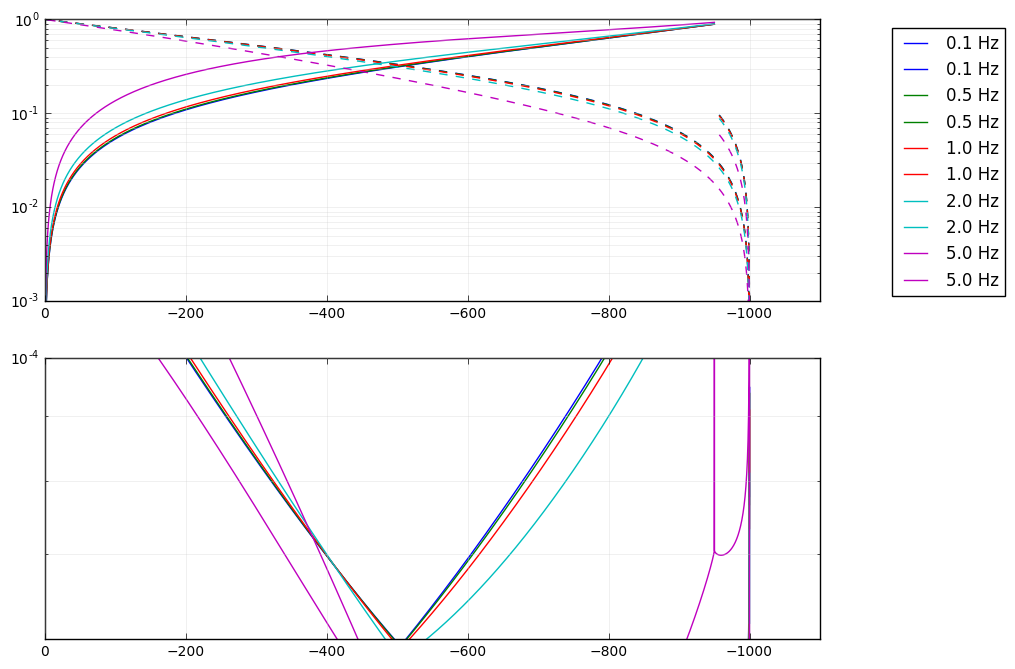

In [30]:
def plotMe_freq(
    muopt, reim, subtract=None, th=True, bh=True, logScale=True, 
    ylim_0l=-1., ylim_0u=1., ylim_1l=6e-5, ylim_1u=1e-4
):
    ylim_0 = [ylim_0l, ylim_0u]
    ylim_1 = [ylim_1l, ylim_1u]
    
    fig, ax = plt.subplots(2,1, figsize=(10,8))
    mur = cp.muModels[muopt]
    
    srcinds = []
    if bh is True: 
        srcinds += [0]
    if th is True:
        srcinds += [1]
    
    plot_currents_over_freq(
        IxCasing, IzCasing, cp, mesh, mur, subtract=subtract, real_or_imag=reim, 
        ax=ax, logScale=logScale, srcinds=srcinds, ylim_0=ylim_0, ylim_1=ylim_1
    )  
    plt.show()

w = widgets.interact(
    plotMe_freq, 
    muopt=widgets.IntSlider(min=0., max=len(cp.muModels)-1, continuousUpdate=False), 
    reim=widgets.ToggleButtons(options=['real', 'imag'], continuousUpdate=False),
    subtract=widgets.ToggleButtons(options=[None, 1]),
    th=widgets.Checkbox(True),
    bh=widgets.Checkbox(True),
    logScale=widgets.ToggleButtons(options=[True, False], continuousUpdate=False), 
    ylim_0l=widgets.FloatText(1e-3, continuousUpdate=False),
    ylim_0u=widgets.FloatText(1, continuousUpdate=False),
    ylim_1l=widgets.FloatText(6e-5, continuousUpdate=False),
    ylim_1u=widgets.FloatText(1e-4, continuousUpdate=False),
)


In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,8))

plot_currents_over_freq(
    IxCasing, IzCasing, cp, mesh, mur=50., real_or_imag='real', 
    ax=ax, logScale=True, srcinds=[1], ylim_0=[1e-2, 1.], ylim_1=[6e-5, 1.5e-4]
) 

ax[0].set_xlabel('z (m)', fontsize=13)
ax[1].set_xlabel('z (m)', fontsize=13)

ax[0].set_ylabel('$I_z$ (A)', fontsize=13)
ax[1].set_ylabel('$I_x$ (A)', fontsize=13)

ax[0].set_title('Vertical Current in Casing')
ax[1].set_title('Horizontal Current in Casing')

plt.tight_layout()

fig.savefig('currents_in_casing.png', dpi=300)

In [ ]:
def plotMe_mu(
    freqopt, reim, subtract=None, th=True, bh=True, logScale=True, 
    ylim_0l=-1., ylim_0u=1., ylim_1l=6e-5, ylim_1u=1e-4
):
    ylim_0 = [ylim_0l, ylim_0u]
    ylim_1 = [ylim_1l, ylim_1u]
#     fig, ax = plt.subplots(2,1, figsize=(10,8))
    freq = cp.freqs[freqopt]
    srcinds = []
    if bh is True: 
        srcinds += [0]
    if th is True:
        srcinds += [1]
    plot_currents_over_mu(
        IxCasing, IzCasing, cp, mesh, freqopt, subtract=subtract, real_or_imag=reim,
        logScale=logScale, srcinds=srcinds, ylim_0=ylim_0, ylim_1=ylim_1
    )  

w = widgets.interact(
    plotMe_mu, 
    freqopt=widgets.IntSlider(min=0., max=len(cp.freqs)-1, continuousUpdate=False), 
    reim=widgets.ToggleButtons(options=['real', 'imag'], continuousUpdate=False),
    subtract=widgets.ToggleButtons(options=[None, 1], continuousUpdate=False),
    th=widgets.Checkbox(True),
    bh=widgets.Checkbox(True),
    logScale=widgets.ToggleButtons(options=[True, False], continuousUpdate=False),
    ylim_0l=widgets.FloatText(1e-3, continuousUpdate=False),
    ylim_0u=widgets.FloatText(1, continuousUpdate=False),
    ylim_1l=widgets.FloatText(6e-5, continuousUpdate=False),
    ylim_1u=widgets.FloatText(1e-4, continuousUpdate=False)
)

w

0.1 Hz


<function __main__.plotMe_j_mu_z>

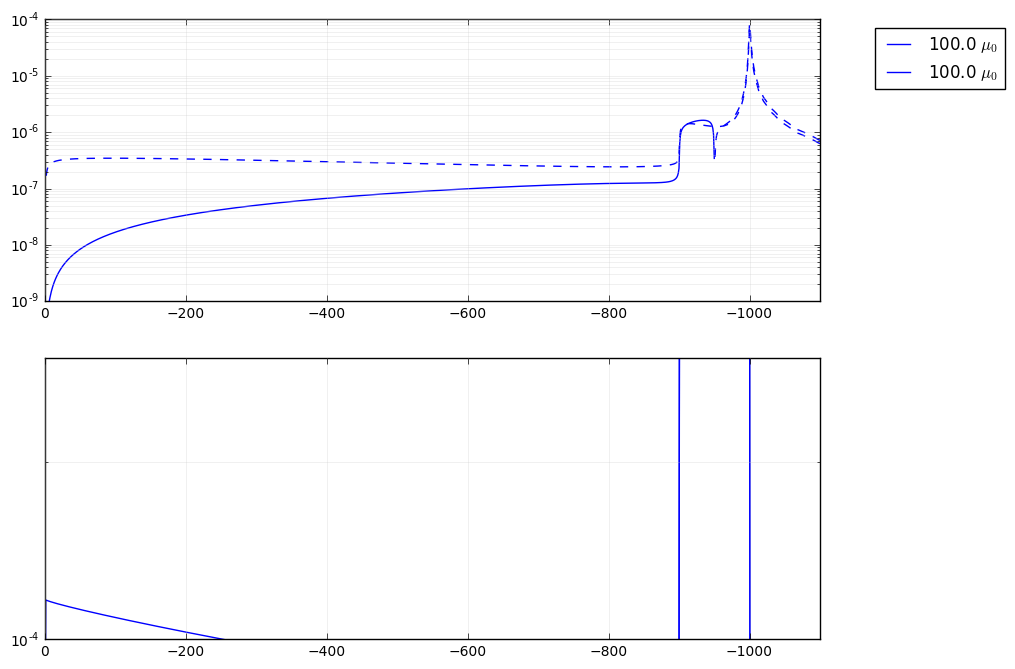

In [151]:
def plotMe_j_mu_z(
    freqopt, reim, r, subtract=None, th=True, bh=True, logScale=True, 
    ylim_0l=-1., ylim_0u=1., ylim_1l=6e-5, ylim_1u=1e-4
):
    ylim_0 = [ylim_0l, ylim_0u]
    ylim_1 = [ylim_1l, ylim_1u]
    fig, ax = plt.subplots(2,1, figsize=(10,8))
    freq = cp.freqs[freqopt]
    
    srcinds = []
    if bh is True: 
        srcinds += [0]
    if th is True:
        srcinds += [1]
        
    plot_j_over_mu_z(
        cp, fields, mesh, survey, freqopt, subtract=subtract, r=r, srcinds=srcinds,
        real_or_imag=reim, ax=ax, ylim_0 = ylim_0, ylim_1 = ylim_1, logScale=logScale
    )  
#     ax[1].set_ylim([1e-4, 3e-4])

widgets.interact(
    plotMe_j_mu_z, 
    freqopt=widgets.IntSlider(min=0., max=len(cp.freqs)-1, continuousUpdate=False), 
    r=widgets.FloatText(value=1., continuousUpdate=False), 
    reim=widgets.ToggleButtons(options=['real', 'imag']),
    subtract=widgets.ToggleButtons(options=[None, 1]),
    th=widgets.Checkbox(True),
    bh=widgets.Checkbox(True),
    logScale=widgets.ToggleButtons(options=[True, False], continuousUpdate=False),
    ylim_0l=widgets.FloatText(1e-9, continuousUpdate=False),
    ylim_0u=widgets.FloatText(1e-4, continuousUpdate=False),
    ylim_1l=widgets.FloatText(1e-4, continuousUpdate=False),
    ylim_1u=widgets.FloatText(3e-4, continuousUpdate=False)
)

In [45]:
from CasingSimulations import plot_j_over_mu_z, plot_j_over_freq_z

5.0 Hz


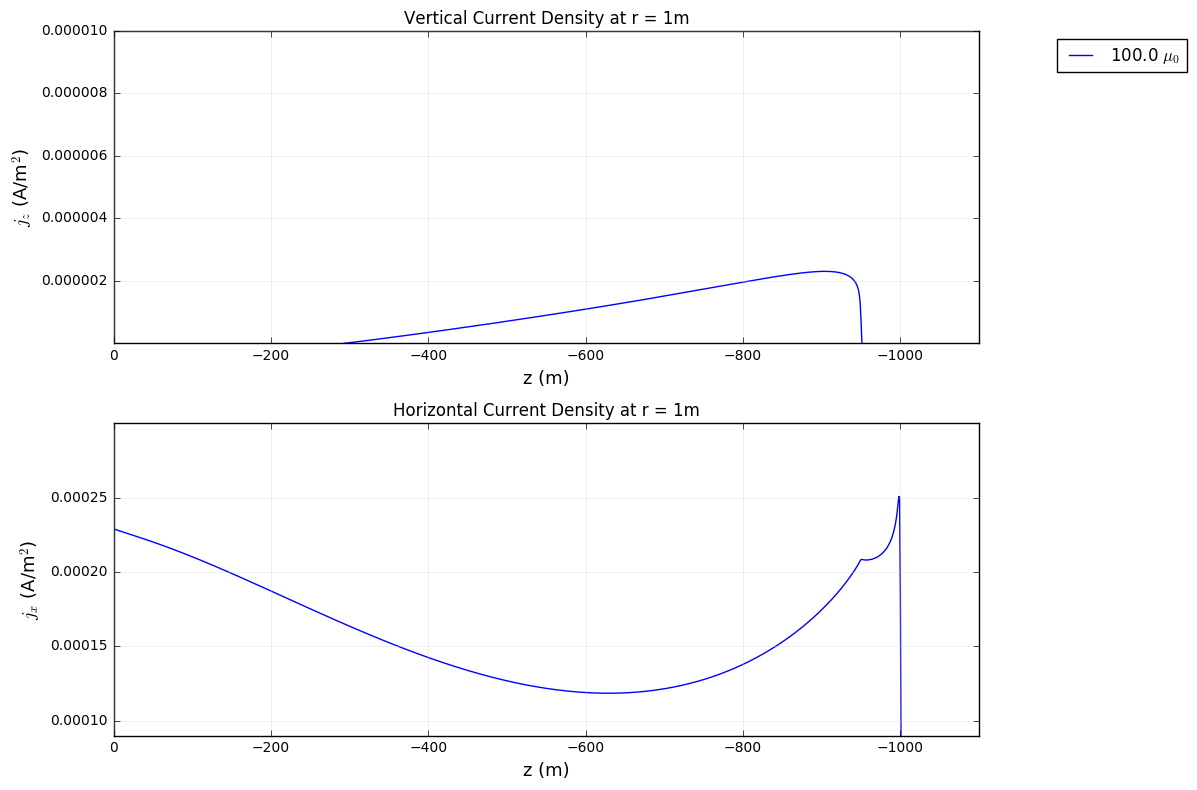

In [43]:
fig, ax = plt.subplots(2,1, figsize=(10,8))

plot_j_over_mu_z(
    cp, fields, mesh, survey, freqind=4, r=1., srcinds=[0],
    real_or_imag='real', ax=ax, ylim_0=[1e-9, 1e-5], ylim_1=[9e-5, 3e-4], fig=fig,logScale=False
)  

ax[0].set_xlabel('z (m)', fontsize=13)
ax[1].set_xlabel('z (m)', fontsize=13)

ax[0].set_ylabel('$j_z$ (A/m$^2$)', fontsize=13)
ax[1].set_ylabel('$j_x$ (A/m$^2$)', fontsize=13)

ax[0].set_title('Vertical Current Density at r = 1m')
ax[1].set_title('Horizontal Current Density at r = 1m')

plt.tight_layout()

fig.savefig('currents_1m_away.png', dpi=300)

mu = 100.0 mu_0


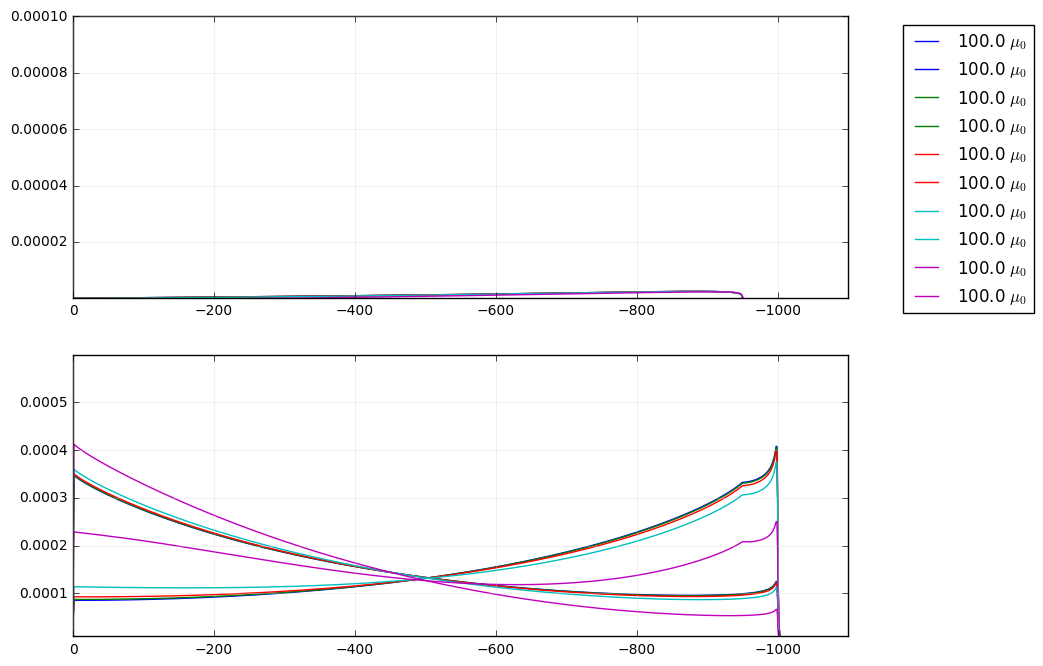

In [46]:
def plotMe_j_freq_z(
    muind, reim, r, subtract=None, th=True, bh=True, logScale=True, 
    ylim_0l=-1., ylim_0u=1., ylim_1l=6e-5, ylim_1u=1e-4
):
    mur = cp.muModels[muind]
    
    ylim_0 = [ylim_0l, ylim_0u]
    ylim_1 = [ylim_1l, ylim_1u]
    fig, ax = plt.subplots(2,1, figsize=(10,8))
    
    srcinds = []
    if bh is True: 
        srcinds += [0]
    if th is True:
        srcinds += [1]
        
    plot_j_over_freq_z(
        cp, fields, mesh, survey, mur, subtract=subtract, r=r, srcinds=srcinds,
        real_or_imag=reim, ax=ax, ylim_0 = ylim_0, ylim_1 = ylim_1, logScale=logScale
    )  
#     ax[1].set_ylim([1e-4, 3e-4])

widgets.interact(
    plotMe_j_freq_z, 
    muind=widgets.IntSlider(min=0., max=len(cp.freqs)-1, continuousUpdate=False), 
    r=widgets.FloatText(value=1., continuousUpdate=False), 
    reim=widgets.ToggleButtons(options=['real', 'imag']),
    subtract=widgets.ToggleButtons(options=[None, 1]),
    th=widgets.Checkbox(True),
    bh=widgets.Checkbox(True),
    logScale=widgets.ToggleButtons(options=[True, False], continuousUpdate=False),
    ylim_0l=widgets.FloatText(1e-9, continuousUpdate=False),
    ylim_0u=widgets.FloatText(1e-4, continuousUpdate=False),
    ylim_1l=widgets.FloatText(1e-4, continuousUpdate=False),
    ylim_1u=widgets.FloatText(3e-4, continuousUpdate=False)
)

mu = 1 mu_0


NameError: global name 'freqind' is not defined

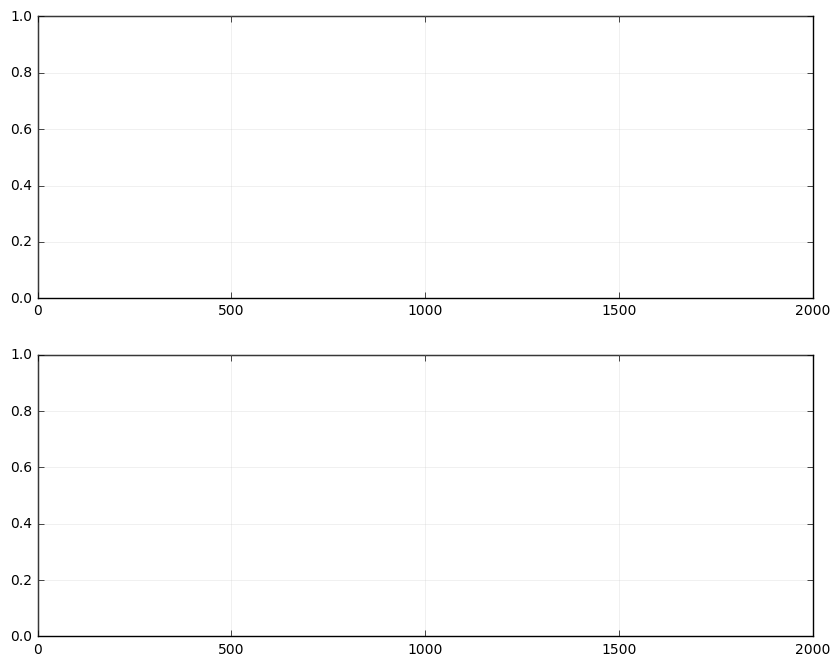

In [30]:
def plotMe_j_mu_x(
    freqopt, reim, z, subtract=None, th=True, bh=True, logScale=True, 
    ylim_0l=-1., ylim_0u=1., ylim_1l=6e-5, ylim_1u=1e-4
):
    ylim_0 = None #[ylim_0l, ylim_0u]
    ylim_1 = None #[ylim_1l, ylim_1u]
    
    fig, ax = plt.subplots(2,1, figsize=(10,8))
    freq = cp.freqs[freqopt]
    srcinds = []
    if bh is True: 
        srcinds += [0]
    if th is True:
        srcinds += [1]
        
    plot_j_over_mu_x(
        cp, fields, mesh, survey, freqopt, subtract=subtract, z=z, real_or_imag=reim, ax=ax,
        srcinds=srcinds, logScale=logScale, ylim_0=ylim_0, ylim_1=ylim_1
    )
    plt.show()

j_over_x = widgets.interactive(
    plotMe_j_mu_x, 
    freqopt=widgets.IntSlider(min=0., max=len(cp.freqs)-1, continuous_update=False), 
    z=widgets.FloatText(value=-950., continuous_update=False), 
    subtract=widgets.ToggleButtons(options=[None, 1], continuous_update=False), 
    reim=widgets.ToggleButtons(options=['real', 'imag'], continuous_update=False),
    th=widgets.Checkbox(True),
    bh=widgets.Checkbox(True),
    logScale=widgets.ToggleButtons(options=[True, False]),
    ylim_0l=widgets.FloatText(1e-9),
    ylim_0u=widgets.FloatText(1e-4),
    ylim_1l=widgets.FloatText(1e-4),
    ylim_1u=widgets.FloatText(3e-4)
)
j_over_x

In [ ]:
fig, ax = plt.subplots(1,1)
col = ['b', 'g', 'r', 'c', 'm', 'y']

for mur in cp.muModels:
    ax.plot(np.zeros(3), label='{} $\mu_0$'.format(mur))
ax.legend()

fig.savefig('mu_legend', dpi=300)

mu = 100.0 mu_0
mu = 100.0 mu_0


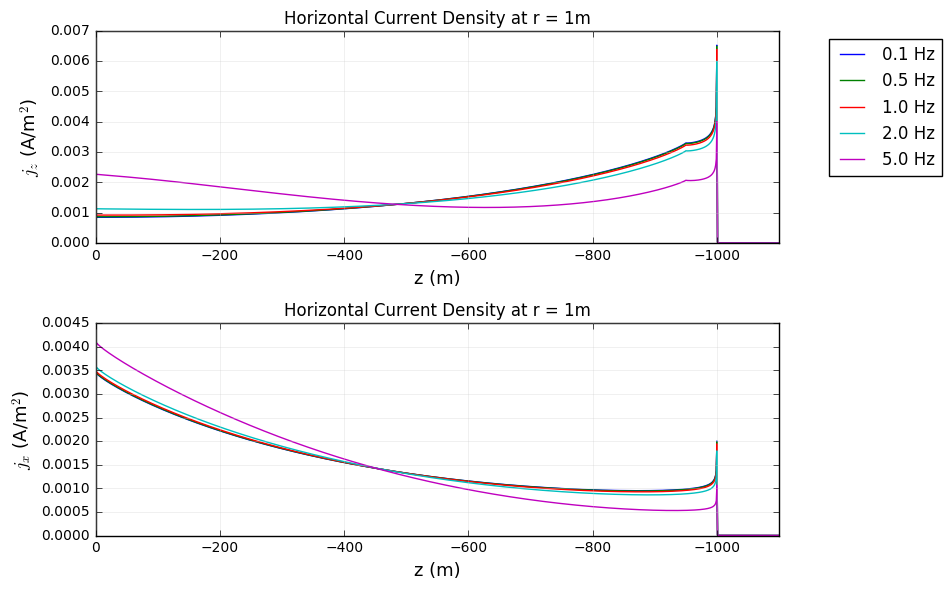

In [76]:
fig, ax = plt.subplots(2,1, figsize=(8,6))
r = 0.1
# plot_j_over_freq_z(
#     cp, fields, mesh, survey, mur=100., r=1., srcinds=[0],
#     real_or_imag='real', ax=ax, ylim_0=[1e-9, 1e-5], ylim_1=[0., 5e-4], fig=fig,logScale=False
# )  
plot_single_j_over_freq_z(
    cp, fields, mesh, survey, mur=100., r=r, srcinds=[0],
    real_or_imag='real', ax=ax[0], ylim=None, fig=fig, logScale=False, legend=True
)

plot_single_j_over_freq_z(
    cp, fields, mesh, survey, mur=100., r=r, srcinds=[1],
    real_or_imag='real', ax=ax[1], ylim=None, fig=fig, logScale=False
)

ax[0].set_xlabel('z (m)', fontsize=13)
ax[1].set_xlabel('z (m)', fontsize=13)

ax[0].set_ylabel('$j_z$ (A/m$^2$)', fontsize=13)
ax[1].set_ylabel('$j_x$ (A/m$^2$)', fontsize=13)

ax[0].set_title('Horizontal Current Density at r = 1m')
ax[1].set_title('Horizontal Current Density at r = 1m')

plt.tight_layout()

# fig.savefig('currents_1m_away.png', dpi=300)

2.0 Hz
2.0 Hz


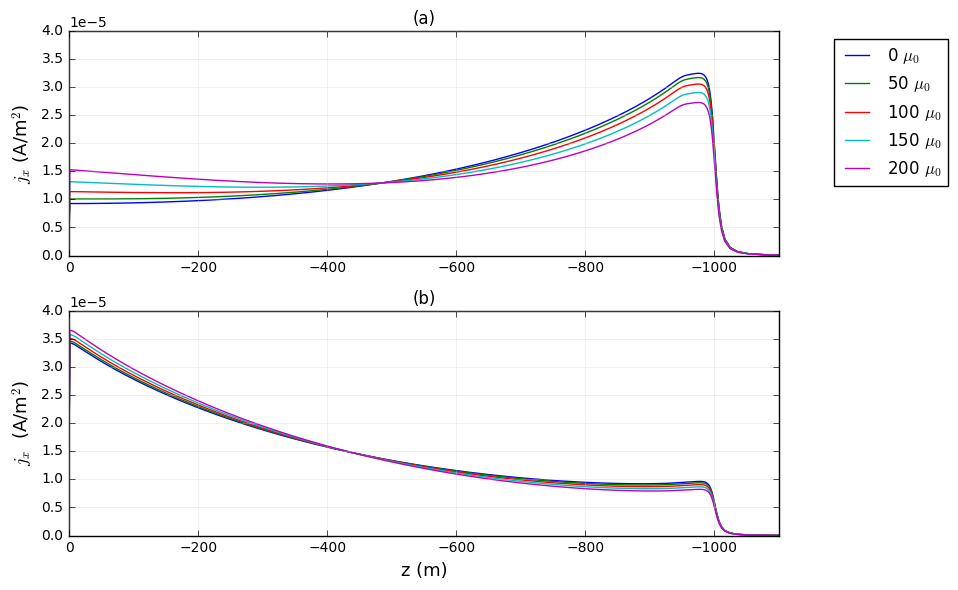

In [85]:
fig, ax = plt.subplots(2,1, figsize=(8,6))
r = 10.
# plot_j_over_freq_z(
#     cp, fields, mesh, survey, mur=100., r=1., srcinds=[0],
#     real_or_imag='real', ax=ax, ylim_0=[1e-9, 1e-5], ylim_1=[0., 5e-4], fig=fig,logScale=False
# )  
plot_single_j_over_mu_z(
    cp, fields, mesh, survey, freqind=0, r=r, srcinds=[0],
    real_or_imag='real', ax=ax[0], ylim=None, fig=fig, logScale=False, legend=True
)

plot_single_j_over_mu_z(
    cp, fields, mesh, survey, freqind=0, r=r, srcinds=[1],
    real_or_imag='real', ax=ax[1], ylim=None, fig=fig, logScale=False
)

# ax[0].set_xlabel('z (m)', fontsize=13)
ax[1].set_xlabel('z (m)', fontsize=13)

ax[0].set_ylabel('$j_x$ (A/m$^2$)', fontsize=13)
ax[1].set_ylabel('$j_x$  (A/m$^2$)', fontsize=13)

ax[0].set_title('(a)')
ax[1].set_title('(b)')

for a in ax:
    a.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
    a.set_ylim([0., 4e-5])
#     a.

plt.tight_layout()

fig.savefig('currents_10m_away.png', dpi=300,bbox_inches='tight' )


In [59]:
a = ax[0]
a

In [71]:
# plot over mu
def plot_single_j_over_freq_z(
    cp, fields, mesh, survey, mur=1., r=1., xlim=[-1100., 0.],
    real_or_imag='real', ax=None, logScale=True, srcinds=[0],
    ylim=None, fig=None, component='x', legend=False
):
    print("mu = {} mu_0".format(mur))

    x_plt = np.r_[r]
    z_plt = np.linspace(xlim[0], xlim[1], int(xlim[1]-xlim[0]))

    XYZ = Utils.ndgrid(x_plt, np.r_[0], z_plt)

    Pfx = mesh.getInterpolationMat(XYZ, 'Fx')
    Pfz = mesh.getInterpolationMat(XYZ, 'Fz')

    Pc = mesh.getInterpolationMat(XYZ, 'CC')
    Zero = sp.csr_matrix(Pc.shape)
    Pcx, Pcz = sp.hstack([Pc, Zero]), sp.hstack([Zero, Pc])

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    ax.grid(
        which='both', linestyle='-', linewidth=0.4,
        color=[0.8, 0.8, 0.8], alpha=0.5
    )

    ax.set_xlim(xlim)
    ax.invert_xaxis()

    col = ['b', 'g', 'r', 'c', 'm', 'y']
    pos_linestyle = ['-', '-']
    neg_linestyle = ['--', '--']
    leg = []

    for i, freq in enumerate(cp.freqs):
        for srcind in srcinds:
            src = survey.getSrcByFreq(freq)[srcind]
            j = Utils.mkvc(fields[mur][src, 'j'].copy())

            if real_or_imag == 'real':
                j = j.real
            else:
                j = j.imag

            if component.upper() == 'X':
                jplt = Pfx * j
            elif component.upper() == 'Z':
                jplt = Pfz * j

            if logScale is True:
                ax.semilogy(
                    z_plt, jplt, '{linestyle}{color}'.format(
                        linestyle=pos_linestyle[srcind],
                        color=col[i]
                    ),
                    label="{} Hz".format(freq)
                )
                ax.semilogy(
                    z_plt, -jplt, '{linestyle}{color}'.format(
                        linestyle=neg_linestyle[srcind],
                        color=col[i]
                    )
                )

            else:
                ax.plot(
                    z_plt, jplt, '{linestyle}{color}'.format(
                        linestyle=pos_linestyle[srcind],
                        color=col[i]
                    ), label="{} Hz".format(freq)
                )

            leg.append(ax)

    if ylim is not None:
        ax.set_ylim(ylim)

    if legend: 
        ax.legend(bbox_to_anchor=[1.25, 1])
    return ax

In [75]:
def plot_single_j_over_mu_z(
    cp, fields, mesh, survey, freqind=0, r=1., xlim=[-1100., 0.],
    real_or_imag='real', subtract=None, ax=None, logScale=True, srcinds=[0],
    ylim=None, fig=None, component='X', legend=False
):
    print("{} Hz".format(cp.freqs[freqind]))

    x_plt = np.r_[r]
    z_plt = np.linspace(xlim[0], xlim[1], int(xlim[1]-xlim[0]))

    XYZ = Utils.ndgrid(x_plt, np.r_[0], z_plt)

    Pfx = mesh.getInterpolationMat(XYZ, 'Fx')
    Pfz = mesh.getInterpolationMat(XYZ, 'Fz')

#     Pc = mesh.getInterpolationMat(XYZ, 'CC')
#     Zero = sp.csr_matrix(Pc.shape)
#     Pcx, Pcz = sp.hstack([Pc, Zero]), sp.hstack([Zero, Pc])

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    ax.grid(
        which='both', linestyle='-', linewidth=0.4,
        color=[0.8, 0.8, 0.8], alpha=0.5
    )
    # getattr(a, 'semilogy' if logScale is True else 'plot')(
    #     [cp.src_a[2], cp.src_a[2]], [1e-14, 1], color=[0.3, 0.3, 0.3]
    # )
    ax.set_xlim(xlim)
    ax.invert_xaxis()

    col = ['b', 'g', 'r', 'c', 'm', 'y']
    pos_linestyle = ['-', '-']
    neg_linestyle = ['--', '--']
    leg = []

    for i, mur in enumerate(cp.muModels):
        for srcind in srcinds:
            src = survey.getSrcByFreq(survey.freqs[freqind])[srcind]
            j = Utils.mkvc(fields[mur][src, 'j'].copy())

            if real_or_imag == 'real':
                j = j.real
            else:
                j = j.imag

            if component.upper() == 'X':
                jplt = Pfx * j
            elif component.upper() == 'Z':
                jplt =  Pfz * j


            if logScale is True:
                ax.semilogy(
                    z_plt, jplt, '{linestyle}{color}'.format(
                        linestyle=pos_linestyle[srcind],
                        color=col[i]
                    ),
                    label="{:3d} $\mu_0$".format(mur)
                )
                ax.semilogy(
                    z_plt, -jplt, '{linestyle}{color}'.format(
                        linestyle=neg_linestyle[srcind],
                        color=col[i]
                    )
                )

            else:
                ax.plot(
                    z_plt, jplt, '{linestyle}{color}'.format(
                        linestyle=pos_linestyle[srcind],
                        color=col[i]
                    ), label="{} $\mu_0$".format(int(mur))
                )

            leg.append(ax)

    if ylim is not  None:
        ax.set_ylim(ylim)

    if legend is True: 
        ax.legend(bbox_to_anchor=[1.25, 1])
    return ax